In [15]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [16]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import scipy.special as scispec
import scipy.optimize
import matplotlib.pyplot as plt
import sympy
from sympy.utilities.lambdify import lambdify
from scipy import optimize
from scipy.optimize import minimize

In [17]:
def build_covariance(x, xp, y, yp, func, tau, L):
    """Build a covariance matrix
    
    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance
    
    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    kern = func
    out = np.zeros((x.shape[0], xp.shape[0]))
    for jj in range(xp.shape[0]):
        out[:, jj] = kern(x, xp[jj], y, yp[jj], tau, L)
    return out

In [18]:
def sqexp(x, xp, y, yp, tau, L):
    """Squared exponential kernel (2 dimensional)
    
    Inputs
    ------
    x : (N), array of multiple inputs
    xp: float
    y : (N), array of multiple inputs
    yp: float
    
    Returns
    -------
    cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov = tau**2 * np.exp(-1/2 * (x - xp)**2 / L**2)*tau**2 * np.exp(-1/2 * (y - yp)**2 / L**2)
    return cov

In [19]:
# constructing gridspace 
n_div = 50
x = np.linspace(-1, 1, n_div)
y = np.linspace(-1, 1, n_div)
xbar, ybar = np.meshgrid(x,y)
xbar_new = np.reshape(xbar,(n_div**2))
ybar_new = np.reshape(ybar,(n_div**2))
ybar_new = ybar_new.T
print(xbar_new.shape)
#print(xbar_new)
print(ybar_new.shape)
#print(ybar_new)

(2500,)
(2500,)


In [20]:
# tau = 0.4
# L = 0.4
# sigma = 0.01
n_init = 22
xinit = np.array([0.1, -0.9, 0.2, 0.8, -0.6, 0.3, 0.5, -0.5, -0.01, -0.9, -0.771, -0.264, -0.474, 0.035, 0.835, -0.814, -0.830,  0.682, 0.331, -0.340, -0.223,  0.698])
xinit = xinit.T
yinit = np.array([0.05, 0.3, 0.4, -0.3, 0.3, -0.2, -0.84, 0.85, -0.76, -0.9, -0.256, -0.236, -0.704, 0.793, -0.726, -0.551,  0.722,  0.633, -0.529, 0.0703,  0.483,  0.168])
yinit = yinit.T
sen_out = np.array([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928, 2.7968011, 3.34929734, 3.91296165, 3.39382006, 3.2073034, 3.39965035, 3.68810201, 4.08231430, 3.13022618, 3.19713096, 3.28089254, 4.16626462, 2.90255492, 4.80939220, 4.60522274])
print((sen_out.T).shape)
sen_out_new = np.reshape(sen_out,(-1,1))
#mean_func = lambda x: np.zeros(((x.shape[0]),1))
#kernel = sqexp(xinit, xbar_new, yinit, ybar_new, tau, l)
#print(kernel)
print(sen_out_new.shape)

(22,)
(22, 1)


In [21]:
def max_marg_likelihood(des_var):
    tau, L, sigma = des_var
    cov = build_covariance(xinit, xinit, yinit, yinit, sqexp, tau, L)

    mean_func = np.mean(sen_out)*np.ones((n_init,1))
    
    subterm_1 = (sen_out_new - mean_func).T
    subterm_2 = np.linalg.pinv(cov + (sigma**2)*np.identity(xinit.shape[0]))
    subterm_3 = sen_out_new - mean_func
    
    term1 = np.dot(subterm_1,np.dot(subterm_2,subterm_3))
    term2 = np.log(np.linalg.det((cov + (sigma**2)*np.identity(xinit.shape[0]))))
    term3 = (n_init)*np.log(2*np.pi)
    
    mx_marg_lh = (1/2)*(term1 + term2 + term3)
    
    return mx_marg_lh
    

In [22]:
const = ((0,None),(0,None),(0,None))
#results = scipy.optimize.minimize(max_marg_likelihood, (0.65, 0.45, 0.01), bounds = const)
#results = scipy.optimize.minimize(max_marg_likelihood, (0.95, 0.5, 0.01), bounds = const)
hyperParameters = scipy.optimize.minimize(max_marg_likelihood, (5.79779452e-01, 2.24441890e-01, 1.06125462e-06), bounds = const)
# results = scipy.optimize.minimize(max_marg_likelihood, (0.7, 0.4, 0.01), bounds = const)
#results = scipy.optimize.minimize(max_marg_likelihood, (0.1, 0.45, 0.001), bounds = const)
# print(results)
print(hyperParameters)


      fun: array([[16.78847233]])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.49213975e-05,  1.84741111e-05,  1.42108547e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 10
   status: 0
  success: True
        x: array([7.21974093e-01, 1.61545364e-01, 1.56412591e-06])


In [23]:
def gpr(xinit, yinit, xpred, ypred, out_sensor, noise_var, mean_func, kernel, tau, L):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xinit: (N, ) training inputs
    yinit: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    ypred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel
    
    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    # constructing covariance matrix from initial datapoints given
    cov = build_covariance(xinit, xinit, yinit, yinit, kernel, tau, L) 
    u, s, v = np.linalg.svd(cov)
    sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))
    mean_func = np.mean(sen_out)*np.ones((n_init,1))
    mean_func = np.mean(sen_out)
    vec_pred = build_covariance(xpred, xinit, ypred, yinit, kernel, tau, L)
    #pred_mean = mean_func + np.dot(vec_pred, np.dot(invcov, out_sensor - mean_func)
    pred_mean = mean_func*np.ones(xpred.shape[0]) + np.matmul(vec_pred, np.matmul(invcov, out_sensor - mean_func))
    
    cov_predict_pre = build_covariance(xpred, xpred, ypred, ypred, kernel, tau, L)
    cov_predict_up = np.dot(vec_pred, np.dot(invcov, vec_pred.T))
    pred_cov = cov_predict_pre - cov_predict_up
    
    return pred_mean, pred_cov

In [34]:
tau = hyperParameters.x[0]
L = hyperParameters.x[1]
sigma = hyperParameters.x[2]
mean_func = np.mean(sen_out)*np.ones((n_init,1))
#mean_func = lambda x: np.zeros((x.shape[0]))
xinit = np.array([0.1, -0.9, 0.2, 0.8, -0.6, 0.3, 0.5, -0.5, -0.01, -0.9, -0.771, -0.264, -0.474, 0.035, 0.835, -0.814, -0.830,  0.682, 0.331, -0.340, -0.223,  0.698])
yinit = np.array([0.05, 0.3, 0.4, -0.3, 0.3, -0.2, -0.84, 0.85, -0.76, -0.9, -0.256, -0.236, -0.704, 0.793, -0.726, -0.551,  0.722,  0.633, -0.529, 0.0703,  0.483,  0.168])
sen_out = np.array([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623, 2.99495501, 3.94274928, 2.7968011, 3.34929734, 3.91296165, 3.39382006, 3.2073034, 3.39965035, 3.68810201, 4.08231430, 3.13022618, 3.19713096, 3.28089254, 4.16626462, 2.90255492, 4.80939220, 4.60522274])
sigma_opt = sigma * np.ones((xinit.shape[0])) 
print(sen_out.shape)
mean_out, cov_out = gpr(xinit, yinit, xbar_new, ybar_new, sen_out, sigma_opt, mean_func, sqexp, tau, L)
x = np.max(mean_out)
print(x)

(22,)
4.799556294718048


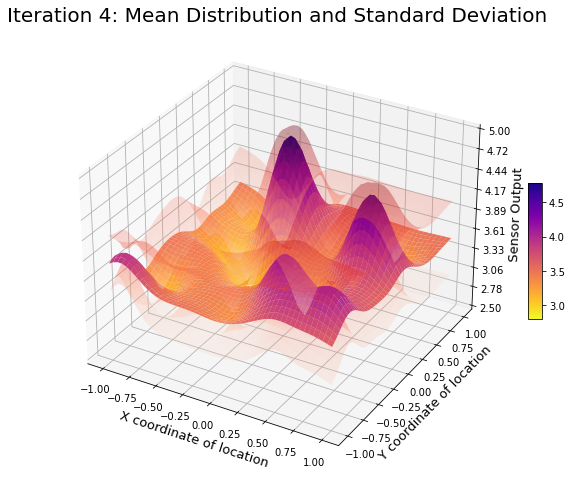

In [28]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10,10))
# Plot the surface.
pred_mean = np.reshape(mean_out, (50,50))
#print(pred_mean)
mean = ax.plot_surface(xbar, ybar, pred_mean, cmap='plasma_r')
var = np.sqrt(np.diag(cov_out))
var_to_plot = np.reshape(var, (50,50))
#print(var_to_plot.shape)
#print(pred_mean.shape)
var_1 = ax.plot_surface(xbar, ybar, pred_mean + var_to_plot, cmap='Reds', alpha = 0.2)
var_2 = ax.plot_surface(xbar, ybar, pred_mean - var_to_plot, cmap='Reds', alpha = 0.2)
#
# Customize the z axis.
ax.set_zlim(2.5, 5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.set_xlabel('X coordinate of location', fontsize = 13)
ax.set_ylabel('Y coordinate of location', fontsize = 13)
ax.set_zlabel('Sensor Output', fontsize = 13)
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_title('Iteration 4: Mean Distribution and Standard Deviation', fontsize = 20)


# Add a color bar which maps values to colors.
fig.colorbar(mean, shrink=0.25, aspect=10)

plt.show()

[[0.14482072 0.10900712 0.08809719 ... 0.25996256 0.26320941 0.26628638]
 [0.10919445 0.06335306 0.03660603 ... 0.24576008 0.25292058 0.2597272 ]
 [0.08859058 0.03694484 0.00679688 ... 0.22121828 0.23513868 0.2483936 ]
 ...
 [0.25111359 0.23889702 0.22568548 ... 0.27028795 0.27106646 0.27144905]
 [0.26125678 0.25506134 0.24834518 ... 0.2711562  0.27145534 0.27160235]
 [0.26703702 0.26427066 0.26125844 ... 0.27151478 0.27161594 0.27166566]]


Text(0, 0.5, 'Y coordinate of locations')

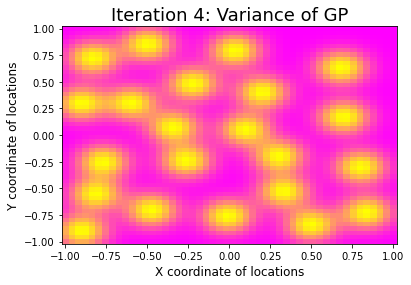

In [32]:
var = np.diag(cov_out)
var_to_plot = np.reshape(var, (50,50))
print(var_to_plot)
c = plt.pcolormesh(xbar,ybar,var_to_plot, cmap = "spring_r")
#x_values = [(results.x[0],results.x[1],results.x[2],results.x[3])]
#y_values = [(results.x[4],results.x[5],results.x[6],results.x[7])]
#plt.scatter(x_values, y_values, c = 'black')
plt.title('Iteration 4: Variance of GP', fontsize = 18)
plt.xlabel('X coordinate of locations', fontsize = 12)
plt.ylabel('Y coordinate of locations', fontsize = 12)

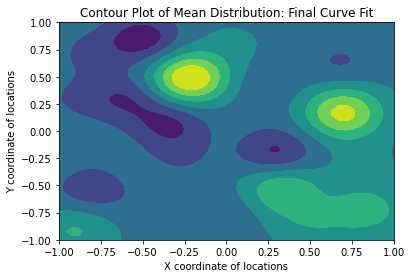

In [38]:
fig, ax = plt.subplots(1, 1)
  
ax.contourf(xbar, ybar, pred_mean)
  
ax.set_title('Contour Plot of Mean Distribution: Final Curve Fit')
ax.set_xlabel('X coordinate of locations')
ax.set_ylabel('Y coordinate of locations')
  
plt.show()